<a href="https://colab.research.google.com/github/bforsbe/SK2534/blob/main/sinc_interpolation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

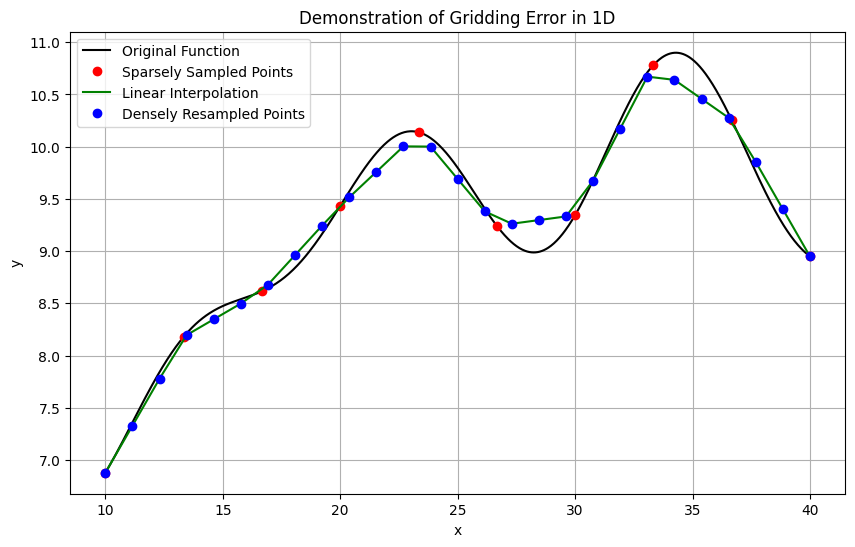

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# 1. Define the test function
def test_function(x):
    return np.sin(x/2) * np.cos(x / 10) + np.sin(x / 20) * 5 + 5

# 2. Sparsely sample the function
x_sparse = np.linspace(10, 40, 10)
y_sparse = test_function(x_sparse)

# 3. Perform linear interpolation
interp_func = interp1d(x_sparse, y_sparse, kind='linear')

# 4. Densely resample the interpolated function
x_dense = np.linspace(10, 40, 27)
y_dense_interp = interp_func(x_dense)

x_pseudo_cont=np.linspace(10,40,1000)
# 5. Visualize the results
plt.figure(figsize=(10, 6))
plt.plot(x_pseudo_cont, test_function(x_pseudo_cont), 'k-', label='Original Function')
plt.plot(x_sparse, y_sparse, 'ro', label='Sparsely Sampled Points')
plt.plot(x_dense, y_dense_interp, 'g-', label='Linear Interpolation')
plt.plot(x_dense, y_dense_interp, 'bo', label='Densely Resampled Points')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Demonstration of Gridding Error in 1D')
plt.legend()
plt.grid(True)
plt.show()

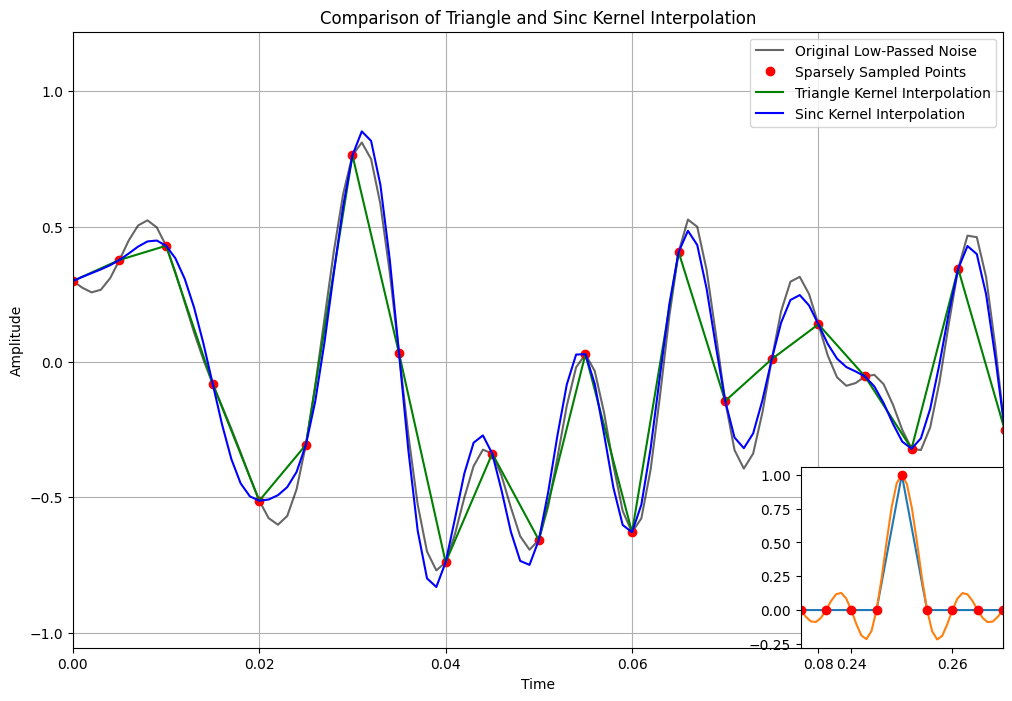

In [ ]:
#@title Generate test data and interpolations

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.interpolate import interp1d
from scipy.fft import fft, ifft, fftfreq

# 1. Generate and low-pass white noise with a hard cutoff
def generate_hard_lowpass_noise(num_points, cutoff_frequency, fs):
    """Generates white noise and applies a hard low-pass filter."""
    t = np.arange(num_points) / fs
    noise = np.random.randn(num_points)

    # Perform FFT
    yf = fft(noise)
    xf = fftfreq(num_points, 1/fs)

    # Apply hard low-pass filter
    yf_filtered = yf.copy()
    yf_filtered[np.abs(xf) > cutoff_frequency] = 0

    # Perform inverse FFT
    filtered_noise = ifft(yf_filtered).real # .real to remove potential small imaginary parts

    return t, filtered_noise

# Parameters for noise generation
num_points = 500 #@param
fs = 1000  #@param # Sampling frequency
cutoff_frequency = 100 #@param # Hz

t_full, noise_full = generate_hard_lowpass_noise(num_points, cutoff_frequency, fs)


# 2. Sparsely sample the noise
sampling_interval = 5 #@param # Tunable parameter: sample every 'sampling_interval' points
x_sparse_indices = np.arange(0, num_points, sampling_interval)
x_sparse = t_full[x_sparse_indices]
y_sparse = noise_full[x_sparse_indices]

# 3. Define kernel functions
def triangle_kernel(x):
    """Triangle kernel function."""
    return np.maximum(0, 1 - np.abs(x))

def sinc_kernel(x):
    """Sinc kernel function."""
    # Handle the case where x is 0 to avoid division by zero
    return np.where(x == 0, 1.0, np.sin(np.pi * x) / (np.pi * x + 1e-9))

# 4. Implement kernel interpolation
def kernel_interpolation(x_sparse, y_sparse, x_target, kernel_func, kernel_width):
    """Performs interpolation using a given kernel function."""
    y_target = np.zeros_like(x_target)
    for i, xt in enumerate(x_target):
        # Calculate the distance from the target point to each sparse point
        distances = (xt - x_sparse) / kernel_width
        # Calculate the kernel weights for each sparse point
        weights = kernel_func(distances)
        # Perform weighted sum
        # Add a small epsilon to the denominator to prevent division by zero
        y_target[i] = np.sum(y_sparse * weights) / (np.sum(weights) + 1e-9) # Add epsilon

    return y_target

# 5. Create wrapper functions
def triangle_interpolation(x_sparse, y_sparse, x_target, kernel_width=None):
    """Triangle kernel interpolation wrapper."""
    if kernel_width is None:
        # Default kernel width to the target grid sampling distance
        if len(x_target) > 1:
             kernel_width = np.mean(np.diff(x_target))
        else:
             kernel_width = 1.0 # Default if only one target point
    return kernel_interpolation(x_sparse, y_sparse, x_target, triangle_kernel, kernel_width)

def sinc_interpolation(x_sparse, y_sparse, x_target, kernel_width=None):
    """Sinc kernel interpolation wrapper."""
    if kernel_width is None:
         # Default kernel width to the target grid sampling distance
        if len(x_target) > 1:
             kernel_width = np.mean(np.diff(x_target))
        else:
             kernel_width = 1.0 # Default if only one target point
    return kernel_interpolation(x_sparse, y_sparse, x_target, sinc_kernel, kernel_width)


# 6. Define target grid
x_target = np.linspace(0, t_full[-1], num_points) # A denser grid for comparison

# 7. Perform interpolations
y_triangle_interp = triangle_interpolation(x_sparse, y_sparse, x_target, kernel_width=sampling_interval/fs)
y_sinc_interp = sinc_interpolation(x_sparse, y_sparse, x_target, kernel_width=sampling_interval/fs) # Using sampling interval for sinc kernel width

# 8. Compare results (Visualize)
f = plt.figure(figsize=(12, 8))
plt.plot(t_full, noise_full, 'k-', alpha=0.6, label='Original Low-Passed Noise')
plt.plot(x_sparse, y_sparse, 'ro', label='Sparsely Sampled Points')
plt.plot(x_target, y_triangle_interp, 'g-', label='Triangle Kernel Interpolation')
plt.plot(x_target, y_sinc_interp, 'b-', label='Sinc Kernel Interpolation')

plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Comparison of Triangle and Sinc Kernel Interpolation')
plt.legend()
plt.grid(True)
plt.xlim(0, 0.2*t_full[-1])


ax = f.add_subplot(3,4,12)
x_temp = np.linspace(-2,2,51)
y_temp = np.zeros_like(x_temp)
y_temp[25] = 1
sampling_interval_temp=np.mean(np.diff(x_temp))

yn = len(y_sparse)
y_sparse_0 = np.zeros(yn)
y_sparse_0[yn//2] = 1

ax.plot(x_target, triangle_interpolation(x_sparse, y_sparse_0, x_target, kernel_width=sampling_interval/fs))
ax.plot(x_target,     sinc_interpolation(x_sparse, y_sparse_0, x_target, kernel_width=sampling_interval/fs))
ax.plot(x_sparse, y_sparse_0,'ro')
ax.set_xlim([0.23,0.27])
plt.show()

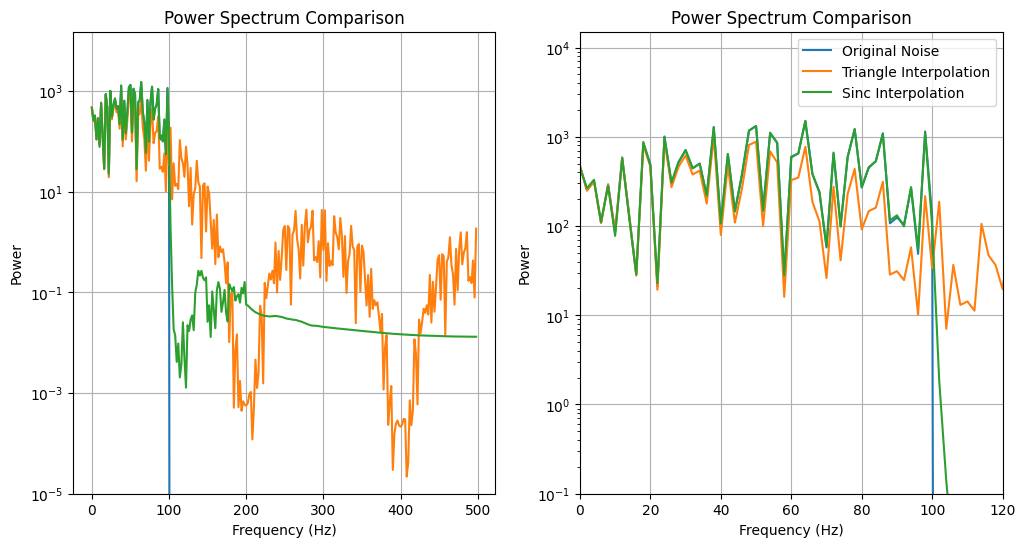

In [ ]:
#@title Calculate Power spectrum

from scipy.fft import fft, fftfreq

# Calculate the power spectrum of the original low-passed noise
# Assuming t_full has a consistent sampling interval
dt_full = t_full[1] - t_full[0]
n_full = len(noise_full)
yf_full = fft(noise_full)
xf_full = fftfreq(n_full, dt_full)[:n_full//2]
power_spectrum_full = np.abs(yf_full[0:n_full//2])**2

# Calculate the power spectrum of the triangle interpolated signal
# Assuming x_target has a consistent sampling interval
dt_target = x_target[1] - x_target[0]
n_target = len(y_triangle_interp)
yf_triangle = fft(y_triangle_interp)
xf_triangle = fftfreq(n_target, dt_target)[:n_target//2]
power_spectrum_triangle = np.abs(yf_triangle[0:n_target//2])**2

# Calculate the power spectrum of the sinc interpolated signal
yf_sinc = fft(y_sinc_interp)
xf_sinc = fftfreq(n_target, dt_target)[:n_target//2]
power_spectrum_sinc = np.abs(yf_sinc[0:n_target//2])**2

# Plot the power spectra
plt.figure(figsize=(12, 6))
ax1 = plt.subplot(1, 2, 1)
ax1.plot(xf_full, power_spectrum_full, label='Original Noise')
ax1.plot(xf_triangle, power_spectrum_triangle, label='Triangle Interpolation')
ax1.plot(xf_sinc, power_spectrum_sinc, label='Sinc Interpolation')
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Power')
ax1.set_title('Power Spectrum Comparison')
ax1.grid(True)
ax1.set_yscale('log') # Use log scale for better visualization of power differences
ax1.set_ylim([1e-5,np.max(power_spectrum_full)*1e1])

ax2 = plt.subplot(1, 2, 2)
ax2.plot(xf_full, power_spectrum_full, label='Original Noise')
ax2.plot(xf_triangle, power_spectrum_triangle, label='Triangle Interpolation')
ax2.plot(xf_sinc, power_spectrum_sinc, label='Sinc Interpolation')
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Power')
ax2.set_title('Power Spectrum Comparison')
ax2.grid(True)
ax2.set_yscale('log') # Use log scale for better visualization of power differences
ax2.set_ylim([1e-1,np.max(power_spectrum_full)*1e1])
ax2.set_xlim([0,cutoff_frequency*1.2])

plt.legend()
plt.show()

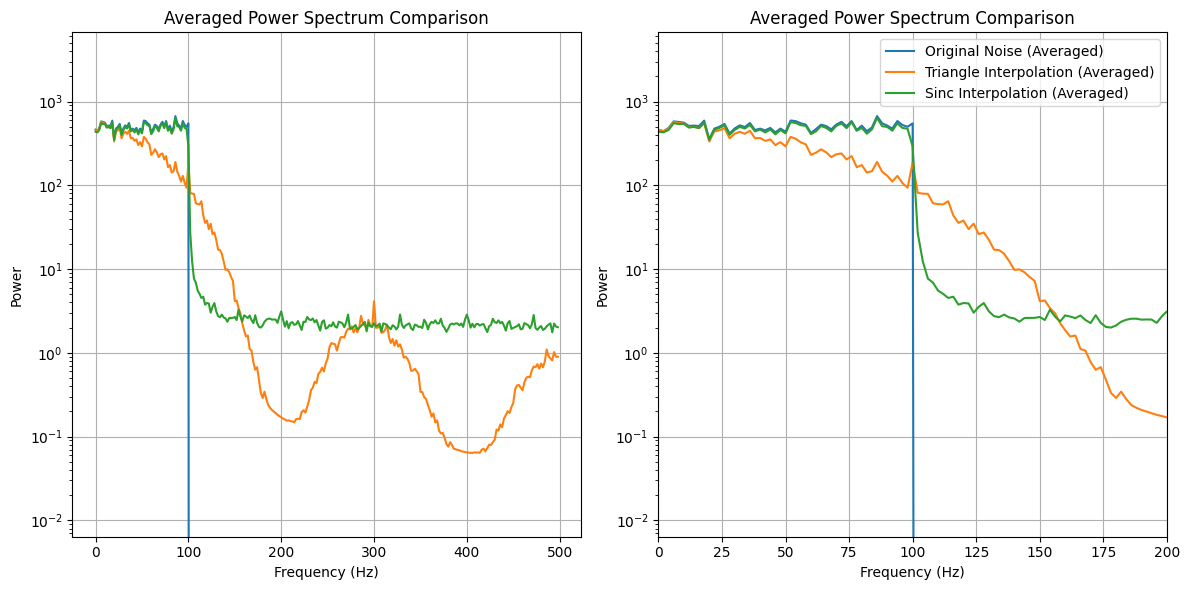

In [ ]:
#@title Averaged Power Spectrum Comparison

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.interpolate import interp1d
from scipy.fft import rfft, irfft, rfftfreq

# Function to generate and low-pass white noise with a hard cutoff
def generate_hard_lowpass_noise(num_points, cutoff_frequency, fs):
    """Generates white noise and applies a hard low-pass filter."""
    t = np.arange(num_points) / fs
    noise = np.random.randn(num_points)

    # Perform FFT
    yf = rfft(noise)
    xf = rfftfreq(num_points, 1/fs)

    # Apply hard low-pass filter
    yf_filtered = yf.copy()
    yf_filtered[np.abs(xf) > cutoff_frequency] = 0

    # Perform inverse FFT
    filtered_noise = irfft(yf_filtered)

    return t, filtered_noise

# Define kernel functions
def triangle_kernel(x):
    """Triangle kernel function."""
    return np.maximum(0, 1 - np.abs(x))

def sinc_kernel(x):
    """Sinc kernel function."""
    return np.where(x == 0, 1.0, np.sin(np.pi * x) / (np.pi * x + 1e-9))

# Implement kernel interpolation
def kernel_interpolation(x_sparse, y_sparse, x_target, kernel_func, kernel_width, finite_support=None):
    """Performs interpolation using a given kernel function."""
    y_target = np.zeros_like(x_target)
    for i, xt in enumerate(x_target):
        distances = (xt - x_sparse) / kernel_width
        weights = kernel_func(distances)
        if finite_support>0:
            weights[np.abs(xt - x_sparse)>=finite_support*kernel_width] = 0
        y_target[i] = np.sum(y_sparse * weights) # / (np.sum(weights) + 1e-9)

    return y_target

# Create wrapper functions
def triangle_interpolation(x_sparse, y_sparse, x_target, kernel_width=None,finite_support=None):
    """Triangle kernel interpolation wrapper."""
    if kernel_width is None:
        if len(x_target) > 1:
             kernel_width = np.mean(np.diff(x_target))
        else:
             kernel_width = 1.0
    return kernel_interpolation(x_sparse, y_sparse, x_target, triangle_kernel, kernel_width,finite_support=finite_support)

def sinc_interpolation(x_sparse, y_sparse, x_target, kernel_width=None,finite_support=None):
    """Sinc kernel interpolation wrapper."""
    if kernel_width is None:
        if len(x_target) > 1:
             kernel_width = np.mean(np.diff(x_target))
        else:
             kernel_width = 1.0
    return kernel_interpolation(x_sparse, y_sparse, x_target, sinc_kernel, kernel_width,finite_support=finite_support)


# Parameters for noise generation and interpolation
num_repeats = 100 #@param {type:"integer"} # Number of realizations to average over
finite_support = -1 #@param

# Define target grid (consistent across all repeats)
t_full_single, _ = generate_hard_lowpass_noise(num_points, cutoff_frequency, fs)
x_target = np.linspace(0, t_full_single[-1], num_points) # Use same density as original

# Initialize storage for power spectra
power_spectra_full = np.zeros((num_repeats, num_points // 2))
power_spectra_triangle = np.zeros((num_repeats, num_points // 2))
power_spectra_sinc = np.zeros((num_repeats, num_points // 2))

# Loop over repeats
for i in range(num_repeats):
    # Generate low-passed noise
    t_full, noise_full = generate_hard_lowpass_noise(num_points, cutoff_frequency, fs)

    # Sparsely sample the noise
    x_sparse_indices = np.arange(0, num_points, sampling_interval)
    x_sparse = t_full[x_sparse_indices]
    y_sparse = noise_full[x_sparse_indices]

    # Perform interpolations
    y_triangle_interp = triangle_interpolation(x_sparse, y_sparse, x_target, kernel_width=sampling_interval/fs,finite_support=finite_support)
    y_sinc_interp = sinc_interpolation(x_sparse, y_sparse, x_target, kernel_width=sampling_interval/fs,finite_support=finite_support)

    # Calculate power spectra
    dt_target = x_target[1] - x_target[0]
    n_target = len(y_triangle_interp)
    xf_target = fftfreq(n_target, dt_target)[:n_target//2] # Frequency axis is the same for all

    yf_full = fft(noise_full)
    power_spectra_full[i, :] = np.abs(yf_full[0:n_target//2])**2

    yf_triangle = fft(y_triangle_interp)
    power_spectra_triangle[i, :] = np.abs(yf_triangle[0:n_target//2])**2

    yf_sinc = fft(y_sinc_interp)
    power_spectra_sinc[i, :] = np.abs(yf_sinc[0:n_target//2])**2

# Average power spectra
averaged_power_spectrum_full = np.mean(power_spectra_full, axis=0)
averaged_power_spectrum_triangle = np.mean(power_spectra_triangle, axis=0)
averaged_power_spectrum_sinc = np.mean(power_spectra_sinc, axis=0)

minv = np.min([np.min(averaged_power_spectrum_sinc),np.min(averaged_power_spectrum_triangle)])


# Plot the averaged power spectra
plt.figure(figsize=(12, 6))
ax1 = plt.subplot(1, 2, 1)
ax1.plot(xf_target, averaged_power_spectrum_full, label='Original Noise (Averaged)')
ax1.plot(xf_target, averaged_power_spectrum_triangle, label='Triangle Interpolation (Averaged)')
ax1.plot(xf_target, averaged_power_spectrum_sinc, label='Sinc Interpolation (Averaged)')
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Power')
ax1.set_title('Averaged Power Spectrum Comparison')
ax1.grid(True)
ax1.set_yscale('log') # Use log scale for better visualization of power differences
#ax1.set_xlim([0,cutoff_frequency*2])
ax1.set_ylim([minv*1e-1,np.max(averaged_power_spectrum_full)*1e1])

ax2 = plt.subplot(1, 2, 2)
ax2.plot(xf_target, averaged_power_spectrum_full, label='Original Noise (Averaged)')
ax2.plot(xf_target, averaged_power_spectrum_triangle, label='Triangle Interpolation (Averaged)')
ax2.plot(xf_target, averaged_power_spectrum_sinc, label='Sinc Interpolation (Averaged)')
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Power')
ax2.set_title('Averaged Power Spectrum Comparison')
ax2.grid(True)
ax2.set_yscale('log') # Use log scale for better visualization of power differences
ax2.set_xlim([0,cutoff_frequency*2])
ax2.set_ylim([minv*1e-1,np.max(averaged_power_spectrum_full)*1e1])


plt.legend()
plt.tight_layout()
plt.show()

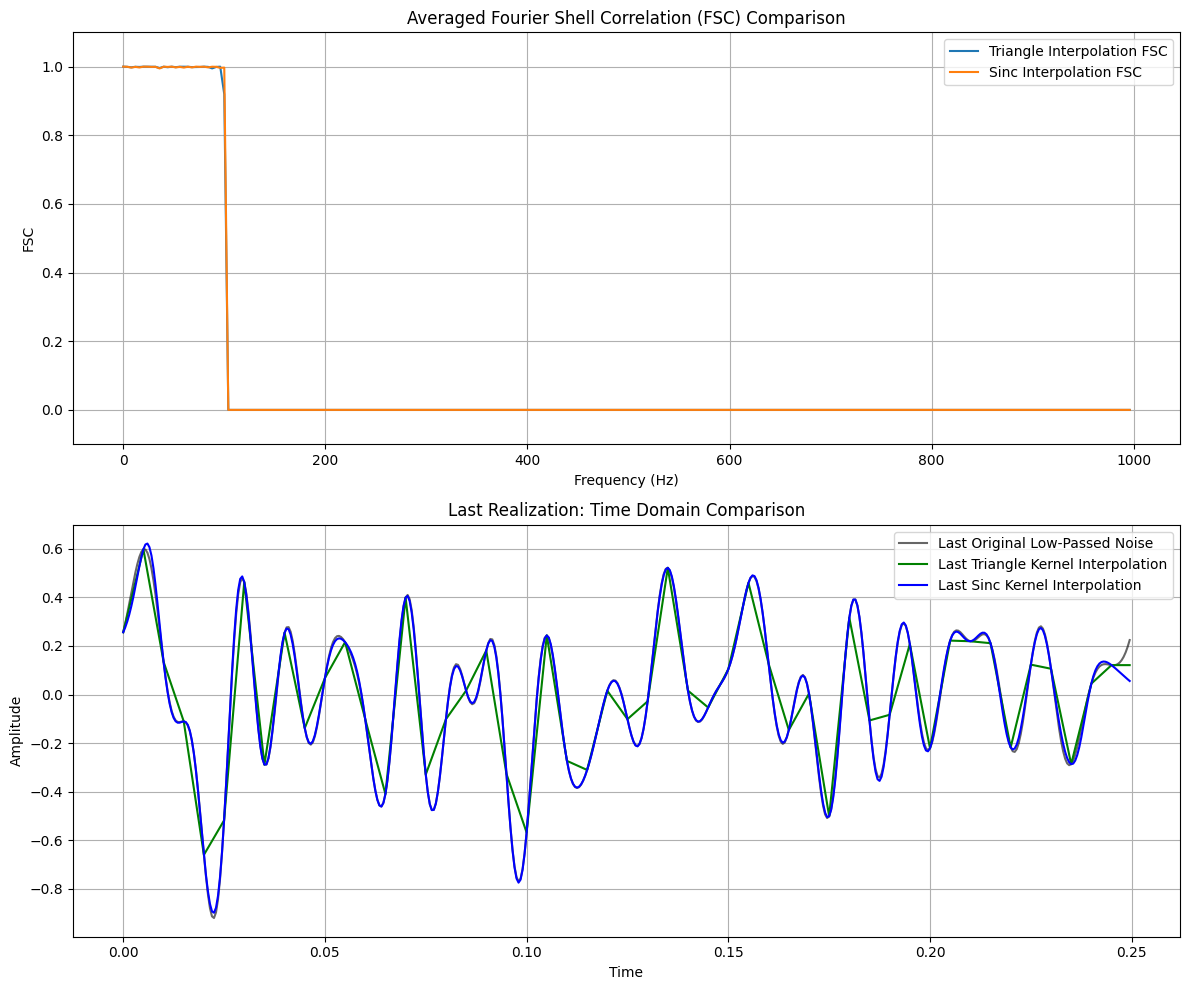

In [ ]:
#@title Averaged Fourier Shell Correlation (FSC) Comparison

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.interpolate import interp1d
from scipy.fft import fft, ifft, fftfreq

# Function to generate and low-pass white noise with a hard cutoff
def generate_hard_lowpass_noise(num_points, cutoff_frequency, fs):
    """Generates white noise and applies a hard low-pass filter."""
    t = np.arange(num_points) / fs
    noise = np.random.randn(num_points)

    # Perform FFT
    yf = fft(noise)
    xf = fftfreq(num_points, 1/fs)

    # Apply hard low-pass filter
    yf_filtered = yf.copy()
    yf_filtered[np.abs(xf) > cutoff_frequency] = 0

    # Perform inverse FFT
    filtered_noise = ifft(yf_filtered).real

    return t, filtered_noise

# Define kernel functions
def triangle_kernel(x):
    """Triangle kernel function."""
    return np.maximum(0, 1 - np.abs(x))

def sinc_kernel(x):
    """Sinc kernel function."""
    return np.where(x == 0, 1.0, np.sin(np.pi * x) / (np.pi * x + 1e-9))

# Implement kernel interpolation
def kernel_interpolation(x_sparse, y_sparse, x_target, kernel_func, kernel_width):
    """Performs interpolation using a given kernel function."""
    y_target = np.zeros_like(x_target)
    for i, xt in enumerate(x_target):
        distances = (xt - x_sparse) / kernel_width
        weights = kernel_func(distances)
        y_target[i] = np.sum(y_sparse * weights) / (np.sum(weights) + 1e-9)

    return y_target

# Create wrapper functions
def triangle_interpolation(x_sparse, y_sparse, x_target, kernel_width=None):
    """Triangle kernel interpolation wrapper."""
    if kernel_width is None:
        if len(x_target) > 1:
             kernel_width = np.mean(np.diff(x_target))
        else:
             kernel_width = 1.0
    return kernel_interpolation(x_sparse, y_sparse, x_target, triangle_kernel, kernel_width)

def sinc_interpolation(x_sparse, y_sparse, x_target, kernel_width=None):
    """Sinc kernel interpolation wrapper."""
    if kernel_width is None:
        if len(x_target) > 1:
             kernel_width = np.mean(np.diff(x_target))
        else:
             kernel_width = 1.0
    return kernel_interpolation(x_sparse, y_sparse, x_target, sinc_kernel, kernel_width)

def calculate_fsc(signal1_fft, signal2_fft):
    """Calculates the Fourier Shell Correlation (FSC) between two FFTs."""
    # Ensure both FFTs have the same length for accurate comparison
    min_len = min(len(signal1_fft), len(signal2_fft))
    signal1_fft = signal1_fft[:min_len]
    signal2_fft = signal2_fft[:min_len]

    # Calculate the cross-spectrum
    cross_spectrum = signal1_fft * np.conj(signal2_fft)

    # Calculate the power spectrum of each signal
    power_spectrum1 = np.abs(signal1_fft)**2
    power_spectrum2 = np.abs(signal2_fft)**2

    # Calculate the FSC
    # Add a small epsilon to the denominator to prevent division by zero
    fsc = np.real(cross_spectrum) / (np.sqrt(power_spectrum1 * power_spectrum2) + 1e-9)

    return fsc


# Parameters for noise generation and interpolation
num_points = 500
fs = 2000  # Sampling frequency
cutoff_frequency = 100 # Hz
sampling_interval = 10 # Tunable parameter: sample every 'sampling_interval' points
num_repeats = 1 #@param {type:"integer"} # Number of realizations to average over

# Define target grid (consistent across all repeats)
t_full_single, _ = generate_hard_lowpass_noise(num_points, cutoff_frequency, fs)
x_target = np.linspace(0, t_full_single[-1], num_points) # Use same density as original
dt_target = x_target[1] - x_target[0]
n_target = len(x_target)
xf_target = fftfreq(n_target, dt_target)[:n_target//2] # Frequency axis for FSC

# Initialize storage for FSC curves
fsc_triangle_repeats = np.zeros((num_repeats, n_target // 2))
fsc_sinc_repeats = np.zeros((num_repeats, n_target // 2))

# Variables to store the last signal and interpolations for plotting
last_t_full = None
last_noise_full = None
last_y_triangle_interp = None
last_y_sinc_interp = None

# Loop over repeats
for i in range(num_repeats):
    # Generate low-passed noise
    t_full, noise_full = generate_hard_lowpass_noise(num_points, cutoff_frequency, fs)

    # Sparsely sample the noise
    x_sparse_indices = np.arange(0, num_points, sampling_interval)
    x_sparse = t_full[x_sparse_indices]
    y_sparse = noise_full[x_sparse_indices]

    # Perform interpolations
    y_triangle_interp = triangle_interpolation(x_sparse, y_sparse, x_target, kernel_width=sampling_interval/fs)
    y_sinc_interp = sinc_interpolation(x_sparse, y_sparse, x_target, kernel_width=sampling_interval/fs)

    # Calculate FFTs
    yf_full = fft(noise_full)
    yf_triangle = fft(y_triangle_interp)
    yf_sinc = fft(y_sinc_interp)

    # Calculate FSCs and store (only positive frequencies)
    fsc_triangle_repeats[i, :] = calculate_fsc(yf_triangle[0:n_target//2], yf_full[0:n_target//2])
    fsc_sinc_repeats[i, :] = calculate_fsc(yf_sinc[0:n_target//2], yf_full[0:n_target//2])

    # Store the last signal and interpolations
    if i == num_repeats - 1:
        last_t_full = t_full
        last_noise_full = noise_full
        last_y_triangle_interp = y_triangle_interp
        last_y_sinc_interp = y_sinc_interp


# Average FSC curves
averaged_fsc_triangle = np.mean(fsc_triangle_repeats, axis=0)
averaged_fsc_sinc = np.mean(fsc_sinc_repeats, axis=0)

# Plot the averaged FSC curves and the last signal/interpolations
plt.figure(figsize=(12, 10))

# Subplot 1: Averaged FSC
ax1 = plt.subplot(2, 1, 1)
ax1.plot(xf_target, averaged_fsc_triangle, label='Triangle Interpolation FSC')
ax1.plot(xf_target, averaged_fsc_sinc, label='Sinc Interpolation FSC')
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('FSC')
ax1.set_title('Averaged Fourier Shell Correlation (FSC) Comparison')
ax1.legend()
ax1.grid(True)
ax1.set_ylim([-0.1, 1.1]) # FSC is between -1 and 1

# Subplot 2: Last signal and interpolations (Time Domain)
ax2 = plt.subplot(2, 1, 2)
ax2.plot(last_t_full, last_noise_full, 'k-', alpha=0.6, label='Last Original Low-Passed Noise')
ax2.plot(x_target, last_y_triangle_interp, 'g-', label='Last Triangle Kernel Interpolation')
ax2.plot(x_target, last_y_sinc_interp, 'b-', label='Last Sinc Kernel Interpolation')
ax2.set_xlabel('Time')
ax2.set_ylabel('Amplitude')
ax2.set_title('Last Realization: Time Domain Comparison')
ax2.legend()
ax2.grid(True)


plt.tight_layout()
plt.show()

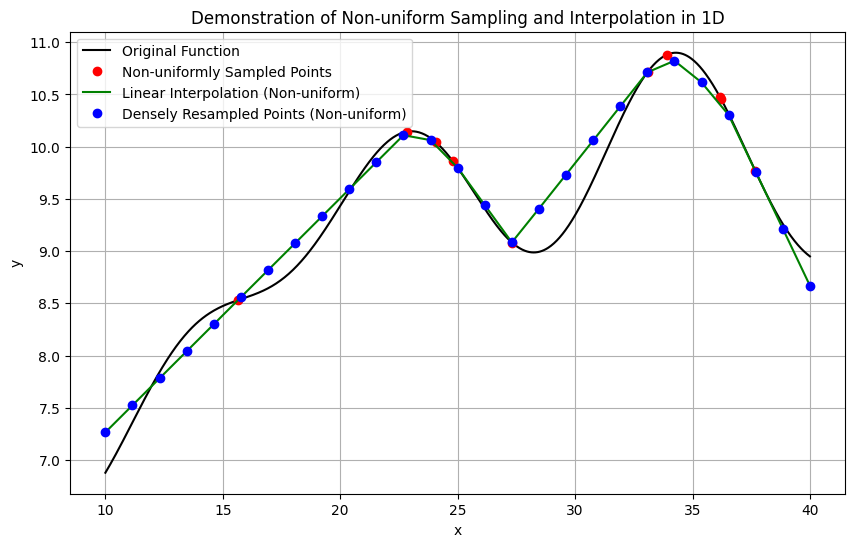

In [16]:
#@title Non-uniform Sampling and Interpolation

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# 1. Define the test function (same as before)
def test_function(x):
    return np.sin(x/2) * np.cos(x / 10) + np.sin(x / 20) * 5 + 5

# 2. Non-uniformly sample the function
num_sparse_points = 10 # Same number of points as before
x_min, x_max = 10, 40

# Generate random positions for the sparse points within the range
x_sparse_nonuniform = np.sort(np.random.uniform(x_min, x_max, num_sparse_points))
y_sparse_nonuniform = test_function(x_sparse_nonuniform)

# 3. Perform linear interpolation on non-uniform data
# Allow extrapolation by setting bounds_error=False and fill_value="extrapolate"
interp_func_nonuniform = interp1d(x_sparse_nonuniform, y_sparse_nonuniform, kind='linear', bounds_error=False, fill_value="extrapolate")

# 4. Densely resample the interpolated function
x_dense_nonuniform = np.linspace(x_min, x_max, 27)
y_dense_interp_nonuniform = interp_func_nonuniform(x_dense_nonuniform)

x_pseudo_cont=np.linspace(x_min,x_max,1000)

# 5. Visualize the results
plt.figure(figsize=(10, 6))
plt.plot(x_pseudo_cont, test_function(x_pseudo_cont), 'k-', label='Original Function')
plt.plot(x_sparse_nonuniform, y_sparse_nonuniform, 'ro', label='Non-uniformly Sampled Points')
plt.plot(x_dense_nonuniform, y_dense_interp_nonuniform, 'g-', label='Linear Interpolation (Non-uniform)')
plt.plot(x_dense_nonuniform, y_dense_interp_nonuniform, 'bo', label='Densely Resampled Points (Non-uniform)')


plt.xlabel('x')
plt.ylabel('y')
plt.title('Demonstration of Non-uniform Sampling and Interpolation in 1D')
plt.legend()
plt.grid(True)
plt.show()

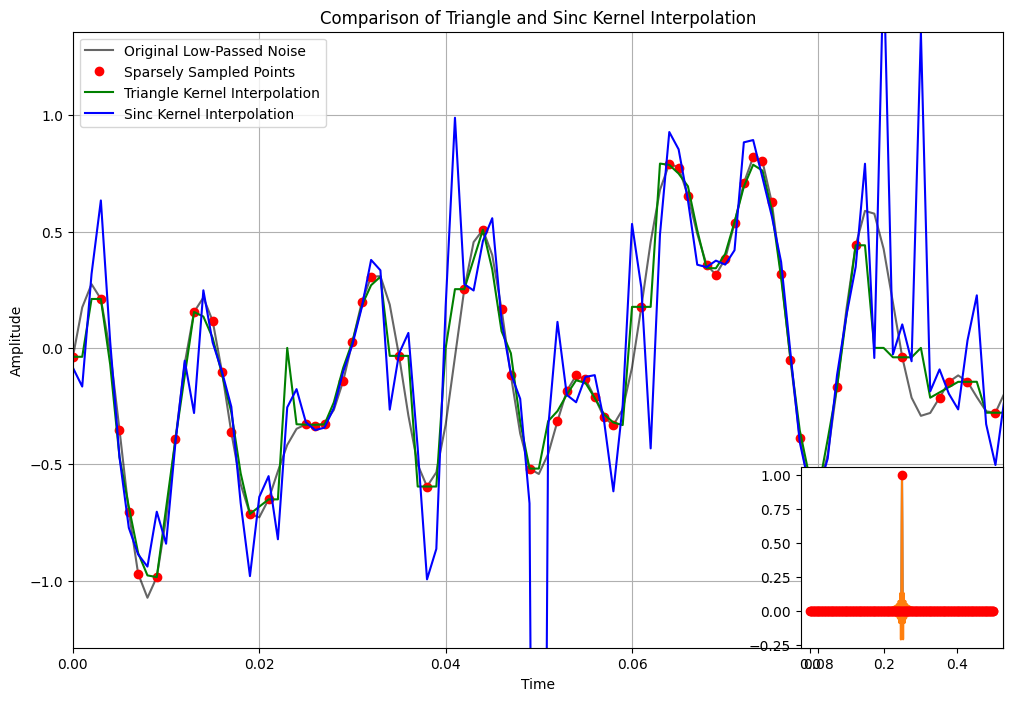

In [27]:
from re import X
#@title Generate test data and interpolations (non-uniform)

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.interpolate import interp1d
from scipy.fft import fft, ifft, fftfreq

# 1. Generate and low-pass white noise with a hard cutoff
def generate_hard_lowpass_noise(num_points, cutoff_frequency, fs):
    """Generates white noise and applies a hard low-pass filter."""
    t = np.arange(num_points) / fs
    noise = np.random.randn(num_points)

    # Perform FFT
    yf = fft(noise)
    xf = fftfreq(num_points, 1/fs)

    # Apply hard low-pass filter
    yf_filtered = yf.copy()
    yf_filtered[np.abs(xf) > cutoff_frequency] = 0

    # Perform inverse FFT
    filtered_noise = ifft(yf_filtered).real # .real to remove potential small imaginary parts

    return t, filtered_noise

# Parameters for noise generation
num_points = 500 #@param
fs = 1000  #@param # Sampling frequency
cutoff_frequency = 100 #@param # Hz

t_full, noise_full = generate_hard_lowpass_noise(num_points, cutoff_frequency, fs)
t_full_nu = np.random.rand(len(t_full))*t_full[-1]
t_full_nu = np.sort(t_full_nu)
t_full_nu[0] = 0
t_full_nu[-1] = num_points/fs
#print(t_full)

# 2. Sparsely sample the noise
sampling_interval = 2 #@param # Tunable parameter: sample every 'sampling_interval' points
x_sparse_indices = np.arange(0, num_points, sampling_interval)
x_sparse_indices_nu = np.random.rand(num_points).argsort()[::sampling_interval]
x_sparse_indices_nu = np.sort(x_sparse_indices_nu)
#print(x_sparse_indices)
#print(x_sparse_indices_nu)


x_sparse = t_full[x_sparse_indices]
y_sparse = noise_full[x_sparse_indices]

x_sparse_nu = t_full[x_sparse_indices_nu]
y_sparse_nu = noise_full[x_sparse_indices_nu]

# 3. Define kernel functions
def triangle_kernel(x):
    """Triangle kernel function."""
    return np.maximum(0, 1 - np.abs(x))

def sinc_kernel(x):
    """Sinc kernel function."""
    # Handle the case where x is 0 to avoid division by zero
    return np.where(x == 0, 1.0, np.sin(np.pi * x) / (np.pi * x + 1e-9))

# 4. Implement kernel interpolation
def kernel_interpolation(x_sparse, y_sparse, x_target, kernel_func, kernel_width):
    """Performs interpolation using a given kernel function."""
    y_target = np.zeros_like(x_target)
    for i, xt in enumerate(x_target):
        # Calculate the distance from the target point to each sparse point
        distances = (xt - x_sparse) / kernel_width
        # Calculate the kernel weights for each sparse point
        weights = kernel_func(distances)
        # Perform weighted sum
        # Add a small epsilon to the denominator to prevent division by zero
        y_target[i] = np.sum(y_sparse * weights) / (np.sum(weights) + 1e-9) # Add epsilon

    return y_target

# 5. Create wrapper functions
def triangle_interpolation(x_sparse, y_sparse, x_target, kernel_width=None):
    """Triangle kernel interpolation wrapper."""
    if kernel_width is None:
        # Default kernel width to the target grid sampling distance
        if len(x_target) > 1:
             kernel_width = np.mean(np.diff(x_target))
        else:
             kernel_width = 1.0 # Default if only one target point
    return kernel_interpolation(x_sparse, y_sparse, x_target, triangle_kernel, kernel_width)

def sinc_interpolation(x_sparse, y_sparse, x_target, kernel_width=None):
    """Sinc kernel interpolation wrapper."""
    if kernel_width is None:
         # Default kernel width to the target grid sampling distance
        if len(x_target) > 1:
             kernel_width = np.mean(np.diff(x_target))
        else:
             kernel_width = 1.0 # Default if only one target point
    return kernel_interpolation(x_sparse, y_sparse, x_target, sinc_kernel, kernel_width)


# 6. Define target grid
x_target = np.linspace(0, t_full[-1], num_points) # A denser grid for comparison

# 7. Perform interpolations
y_triangle_interp_nu = triangle_interpolation(x_sparse_nu, y_sparse_nu, x_target, kernel_width=sampling_interval/fs)
y_sinc_interp_nu = sinc_interpolation(x_sparse_nu, y_sparse_nu, x_target, kernel_width=sampling_interval/fs) # Using sampling interval for sinc kernel width

# 8. Compare results (Visualize)
f = plt.figure(figsize=(12, 8))
plt.plot(t_full, noise_full, 'k-', alpha=0.6, label='Original Low-Passed Noise')
plt.plot(x_sparse_nu, y_sparse_nu, 'ro', label='Sparsely Sampled Points')
plt.plot(x_target, y_triangle_interp_nu, 'g-', label='Triangle Kernel Interpolation')
plt.plot(x_target, y_sinc_interp_nu, 'b-', label='Sinc Kernel Interpolation')

plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Comparison of Triangle and Sinc Kernel Interpolation')
plt.legend()
plt.grid(True)
plt.xlim(0, 0.2*t_full[-1])
plt.ylim(1.2*np.min(noise_full),1.2*np.max(noise_full))


ax = f.add_subplot(3,4,12)
x_temp = np.linspace(-2,2,51)
y_temp = np.zeros_like(x_temp)
y_temp[25] = 1
sampling_interval_temp=np.mean(np.diff(x_temp))

yn = len(y_sparse)
y_sparse_0 = np.zeros(yn)
y_sparse_0[yn//2] = 1

ax.plot(x_target, triangle_interpolation(x_sparse, y_sparse_0, x_target, kernel_width=sampling_interval/fs))
ax.plot(x_target,     sinc_interpolation(x_sparse, y_sparse_0, x_target, kernel_width=sampling_interval/fs))
ax.plot(x_sparse, y_sparse_0,'ro')
#ax.set_xlim([0.23,0.27])
plt.show()

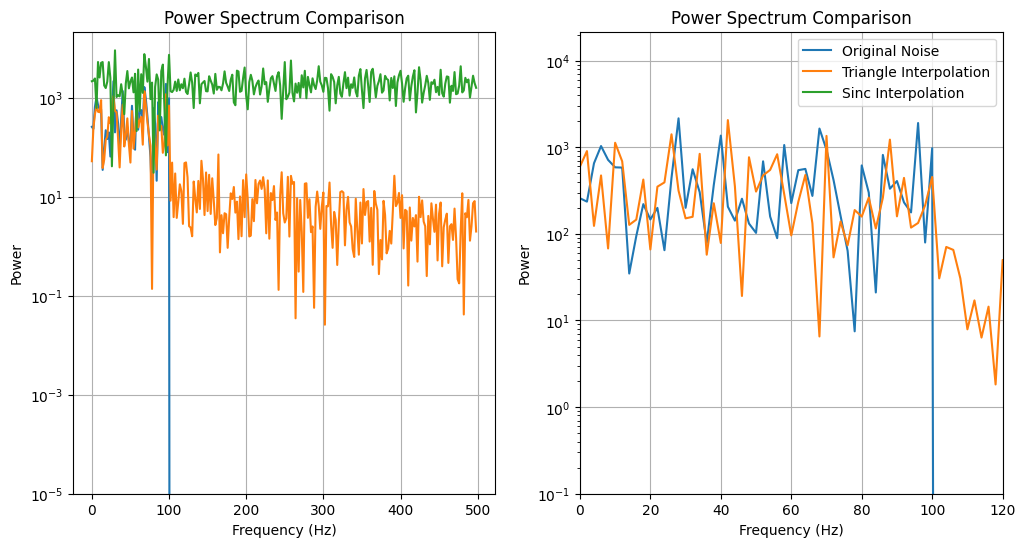

In [28]:
#@title Calculate Power spectrum

from scipy.fft import fft, fftfreq

# Calculate the power spectrum of the original low-passed noise
# Assuming t_full has a consistent sampling interval
dt_full = t_full[1] - t_full[0]
n_full = len(noise_full)
yf_full = fft(noise_full)
xf_full = fftfreq(n_full, dt_full)[:n_full//2]
power_spectrum_full = np.abs(yf_full[0:n_full//2])**2

# Calculate the power spectrum of the triangle interpolated signal
# Assuming x_target has a consistent sampling interval
dt_target = x_target[1] - x_target[0]
n_target = len(y_triangle_interp)
yf_triangle_nu = fft(y_triangle_interp_nu)
xf_triangle = fftfreq(n_target, dt_target)[:n_target//2]
power_spectrum_triangle_nu = np.abs(yf_triangle_nu[0:n_target//2])**2

# Calculate the power spectrum of the sinc interpolated signal
yf_sinc_nu = fft(y_sinc_interp_nu)
xf_sinc = fftfreq(n_target, dt_target)[:n_target//2]
power_spectrum_sinc_nu = np.abs(yf_sinc_nu[0:n_target//2])**2

# Plot the power spectra
plt.figure(figsize=(12, 6))
ax1 = plt.subplot(1, 2, 1)
ax1.plot(xf_full, power_spectrum_full, label='Original Noise')
ax1.plot(xf_triangle, power_spectrum_triangle_nu, label='Triangle Interpolation')
ax1.plot(xf_sinc, power_spectrum_sinc_nu, label='Sinc Interpolation')
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Power')
ax1.set_title('Power Spectrum Comparison')
ax1.grid(True)
ax1.set_yscale('log') # Use log scale for better visualization of power differences
ax1.set_ylim([1e-5,np.max(power_spectrum_full)*1e1])

ax2 = plt.subplot(1, 2, 2)
ax2.plot(xf_full, power_spectrum_full, label='Original Noise')
ax2.plot(xf_triangle, power_spectrum_triangle, label='Triangle Interpolation')
ax2.plot(xf_sinc, power_spectrum_sinc, label='Sinc Interpolation')
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Power')
ax2.set_title('Power Spectrum Comparison')
ax2.grid(True)
ax2.set_yscale('log') # Use log scale for better visualization of power differences
ax2.set_ylim([1e-1,np.max(power_spectrum_full)*1e1])
ax2.set_xlim([0,cutoff_frequency*1.2])

plt.legend()
plt.show()